
# 3.TELECOM CHURN CASE STUDY

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [22]:
import pandas as pd

# Load the dataset
telecom_data = pd.read_csv('/content/drive/MyDrive/Upgrad_Projects /telecom_churn_data.csv')

# Display the first few rows of the dataset
print(telecom_data.head())

# Check the shape of the dataset
print("Shape of the dataset:", telecom_data.shape)

# Check for missing values
print("Missing values:\n", telecom_data.isnull().sum())

# Check data types of each column
print("Data types:\n", telecom_data.dtypes)


   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.385  ...     

In [23]:
recharge_amount_70th_percentile = telecom_data.groupby('mobile_number')[['total_rech_amt_6', 'total_rech_amt_7']].mean().sum(axis=1).quantile(0.7)
high_value_customers = telecom_data[(telecom_data['total_rech_amt_6'] + telecom_data['total_rech_amt_7']) >= recharge_amount_70th_percentile]

# Tag churners
churn_phase_columns = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
high_value_customers['churn'] = np.where((high_value_customers[churn_phase_columns].sum(axis=1) == 0), 1, 0)

<ipython-input-23-c441d413f2fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_value_customers['churn'] = np.where((high_value_customers[churn_phase_columns].sum(axis=1) == 0), 1, 0)


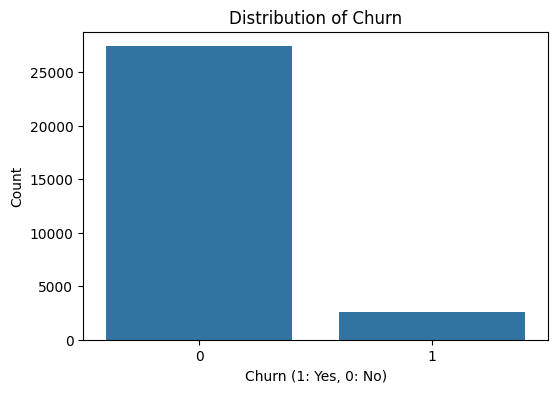

In [24]:
# Visualize the distribution of churn
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=high_value_customers)
plt.title('Distribution of Churn')
plt.xlabel('Churn (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

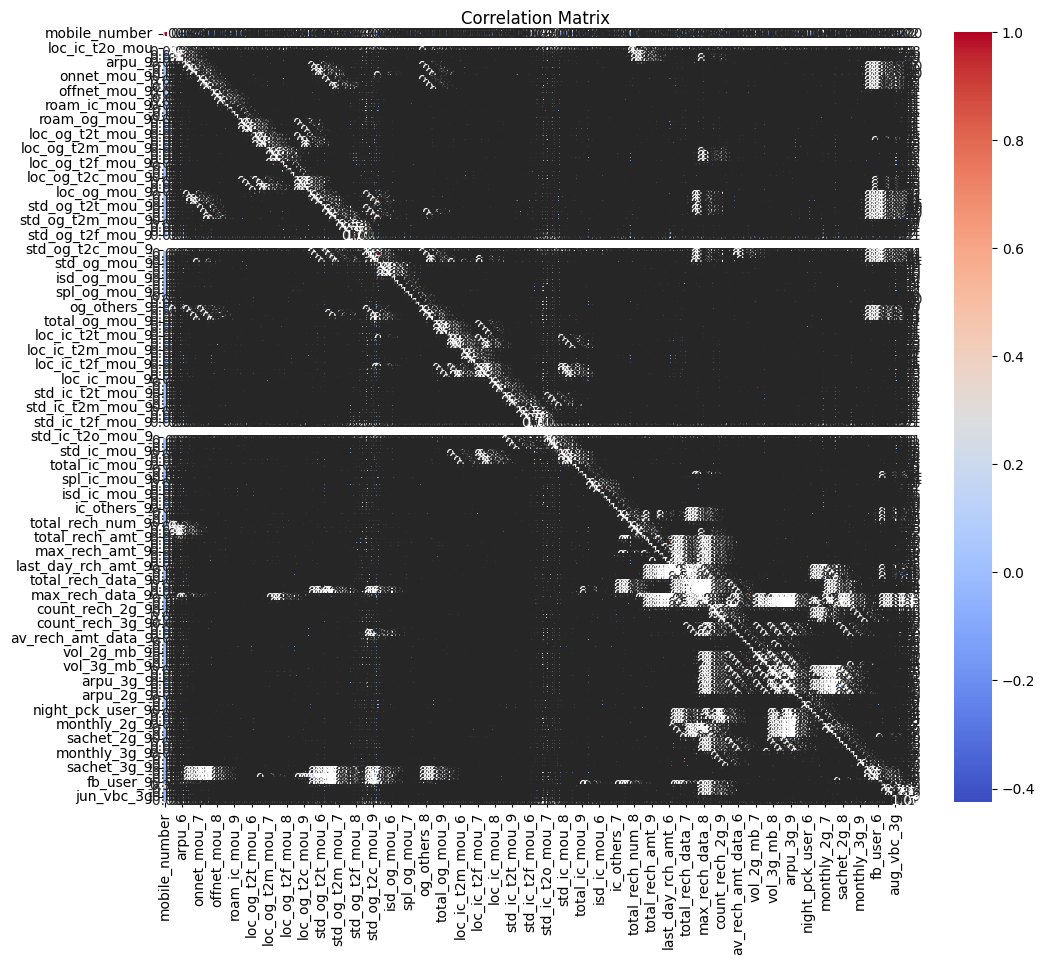

In [5]:
# Drop non-numeric columns
numeric_data = telecom_data.select_dtypes(include=np.number)

# Correlation analysis
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [25]:
# Calculate the total recharge amount for June and July
total_rech_amt_6 = telecom_data['total_rech_amt_6']
total_rech_amt_7 = telecom_data['total_rech_amt_7']

# Calculate the average recharge amount for each customer for the first two months
average_rech_amt = (total_rech_amt_6 + total_rech_amt_7) / 2

# Find the 70th percentile of the average recharge amount
seventieth_percentile = np.percentile(average_rech_amt, 70)

# Filter high-value customers
high_value_customers = telecom_data[average_rech_amt >= seventieth_percentile]

# Display the number of high-value customers
print("Number of high-value customers:", len(high_value_customers))


Number of high-value customers: 30011


In [26]:
# Tag churners
telecom_data['churn'] = ((telecom_data['total_ic_mou_9'] == 0) &
                         (telecom_data['total_og_mou_9'] == 0) &
                         (telecom_data['vol_2g_mb_9'] == 0) &
                         (telecom_data['vol_3g_mb_9'] == 0)).astype(int)

# Remove attributes of the churn phase
churn_phase_attributes = [col for col in telecom_data.columns if '_9' in col]
telecom_data.drop(churn_phase_attributes, axis=1, inplace=True)

# Display the updated dataset
print(telecom_data.head())


   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014  197.385   
1            6/30/2014            7/31/2014            8/31/2014   34.047   
2            6/30/2014            7/31/2014            8/31/2014  167.690   
3            6/30/2014            7/31/2014            8/31/2014  221.338   
4            6/30/2014            7/31/2014            8/31/2014  261.636   

    arpu_7  ...  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8 

In [ ]:
# Splitting the data into features (X) and target (y)
X = telecom_data.drop(columns=['churn'])
y = telecom_data['churn']

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Check data types of all columns
telecom_data.head()


In [ ]:
# Feature scaling (excluding date columns)
scaler = StandardScaler()

# Exclude date columns from feature scaling
date_columns = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8','date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8','date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled.drop(columns=date_columns, inplace=True)
X_test_scaled.drop(columns=date_columns, inplace=True)

# Perform feature scaling
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)


In [33]:
from sklearn.impute import SimpleImputer

# Define the imputer transformer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

# Perform feature scaling
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [34]:
# Model Building
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC()
}

In [ ]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training Gradient Boosting...
Training Support Vector Machine...


In [17]:
# Model Evaluation
print("\nModel Evaluation:")
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")


Model Evaluation:

Logistic Regression:
Accuracy: 0.9307
Precision: 0.8028
Recall: 0.4399
F1-score: 0.5684
ROC-AUC: 0.7137

Random Forest:
Accuracy: 0.9412
Precision: 0.7899
Recall: 0.5895
F1-score: 0.6751
ROC-AUC: 0.7857

Gradient Boosting:
Accuracy: 0.9426
Precision: 0.7759
Recall: 0.6281
F1-score: 0.6942
ROC-AUC: 0.8036

Support Vector Machine:
Accuracy: 0.9288
Precision: 0.8407
Recall: 0.3869
F1-score: 0.5299
ROC-AUC: 0.6892


In [ ]:
# Extracting feature importances from the best model (Gradient Boosting)
best_model = models['Gradient Boosting']
feature_importances = best_model.feature_importances_

# Pairing feature importances with column names
feature_importance_dict = dict(zip(X_train.columns, feature_importances))

# Sorting feature importances
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Displaying top 10 features
print("\nTop 10 Features:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance:.4f}")


In [ ]:
# Exclude non-numeric columns
numeric_columns = telecom_data.select_dtypes(include=np.number).columns

# Explore correlations between numeric features and target variable
correlation_with_target = telecom_data[numeric_columns].corr()['churn'].sort_values(ascending=False)
# Drop columns with NaN correlation coefficients
correlation_with_target = correlation_with_target.dropna()

# Display the updated correlation coefficients
print("Correlation with target variable (churn):\n", correlation_with_target)



In [ ]:
import seaborn as sns

# Calculate correlation with churn and sort values
correlation_with_target = correlation_with_target.drop('churn')  # Exclude churn correlation with itself
correlation_with_target_sorted = correlation_with_target.abs().sort_values(ascending=False)

# Filter top features with significant correlations
top_features = correlation_with_target_sorted[correlation_with_target_sorted > 0.1]  # Adjust threshold as needed

# Plot bar plot for top features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.index, y=top_features.values, palette='coolwarm')
plt.title('Top Numeric Features Correlated with Churn')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()
